### Analysis on the Global Terrorism Database (GTD) maintained by the University of Maryland to classify and predict if attacks are perpertrated by domestic or foreign nationals using Random Forest algorithm. 

### Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))
matplotlib.style.use('ggplot')


In [2]:
%matplotlib inline

### Data wrangling and preprocessing

The dataset was downloaded as an excel spreadsheet from the GTD website, uploaded into Pandas and then we carry out some data wrangling and preprocessing.

In [3]:
file= r'C:\Users\dejavu\Desktop\git_jupyter\springboard_mini_project\capstone_projects/globalterrorismdb_0617dist.xlsx'
df= pd.read_excel(file)

In [4]:
df.shape

(170350, 135)

In [5]:
#restrict this dataset to occurrences in the US.
df1= df['country_txt'].str.contains('United States')
df2= df[df1]
df2.head(3)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
5,197001010002,1970,1,1,NaN,0,NaT,217,United States,1,...,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN
7,197001020002,1970,1,2,NaN,0,NaT,217,United States,1,...,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN
8,197001020003,1970,1,2,NaN,0,NaT,217,United States,1,...,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN


In [6]:
df2.shape

(2758, 135)

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2758 entries, 5 to 169902
Columns: 135 entries, eventid to related
dtypes: datetime64[ns](1), float64(53), int64(24), object(57)
memory usage: 2.9+ MB


In [8]:
class wr_ppro():
    '''Used for data wrangling and some initial preprocessing'''
    def __init__(self):
        ''''''
    def drop_col_nan(self, x, threshold):
        for col in x.columns:
            amt = sum(x[col].isnull())/float(len(x)) * 100
            if amt > threshold:
                x = x.drop(col,1)
                pd.set_option('display.max_columns', None)
        return x
        
    def drop_noisy_col(self, y, w=[]):
        y=y.drop(w, 1)
        return y
                
    def drop_col_txt(self, z):
        for c in z.columns:
            c = str(c)
            if c[-3:] =='txt':
                z = z.drop(c, 1)
                pd.set_option('display.max_columns', None)
        return z     
       

In [9]:
df3=wr_ppro().drop_col_nan(df2, 80)

In [10]:
df3.index = range(len(df2))

In [11]:
df4=wr_ppro().drop_col_txt(df3)

In [12]:
df5=wr_ppro().drop_noisy_col(df4, ['corp1', 'motive', 'target1', 'weapdetail','country','addnotes', 'summary', 'scite1' , 'scite2' , 'scite3' , 'dbsource', 'INT_LOG' ,'longitude','specificity', 'eventid', 'location','region', 'propcomment', 'latitude'])

In [13]:
df5.shape

(2758, 40)

In [14]:
df5.isnull().sum()

iyear              0
imonth             0
iday               0
extended           0
provstate          0
city               0
vicinity           0
crit1              0
crit2              0
crit3              0
doubtterr          0
multiple           0
success            0
suicide            0
attacktype1        0
targtype1          0
targsubtype1     120
natlty1            9
gname              0
guncertain1        0
individual         0
nperps           982
nperpcap        1055
claimed         1051
weaptype1          0
weapsubtype1     259
nkill             73
nkillus          953
nkillter        1004
nwound            93
nwoundus         973
nwoundte        1018
property           0
propextent      1191
propvalue       1840
ishostkid        176
ransom           588
INT_IDEO           0
INT_MISC           0
INT_ANY            0
dtype: int64

In [15]:
df5.dtypes

iyear             int64
imonth            int64
iday              int64
extended          int64
provstate        object
city             object
vicinity          int64
crit1             int64
crit2             int64
crit3             int64
doubtterr         int64
multiple          int64
success           int64
suicide           int64
attacktype1       int64
targtype1         int64
targsubtype1    float64
natlty1         float64
gname            object
guncertain1     float64
individual        int64
nperps          float64
nperpcap        float64
claimed         float64
weaptype1         int64
weapsubtype1    float64
nkill           float64
nkillus         float64
nkillter        float64
nwound          float64
nwoundus        float64
nwoundte        float64
property          int64
propextent      float64
propvalue       float64
ishostkid       float64
ransom          float64
INT_IDEO          int64
INT_MISC          int64
INT_ANY           int64
dtype: object

***Exporting the DataFrame to Excel for more analysis***

In [16]:
#writer = pd.ExcelWriter('abc2_xlsx', engine='xlsxwriter')
#df5.to_excel(writer, sheet_name='Sheet1')
#writer.save()

***Imputing Missing Values***

In [17]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with median of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [18]:
df6 = DataFrameImputer().fit_transform(df5)
df6.head()

,iyear,imonth,iday,extended,provstate,city,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,targtype1,targsubtype1,natlty1,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,ishostkid,ransom,INT_IDEO,INT_MISC,INT_ANY
0,1970,1,1,0,Illinois,Cairo,0,1,1,1,0,0,1,0,2,3,22.0,217.0,Black Nationalists,0.0,0,-99.0,-99.0,0.0,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,-9,0,-9
1,1970,1,2,0,California,Oakland,0,1,1,1,1,0,1,0,3,21,107.0,217.0,Unknown,0.0,0,-99.0,-99.0,0.0,6,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,22500.0,0.0,0.0,-9,0,-9
2,1970,1,2,0,Wisconsin,Madison,0,1,1,1,0,0,1,0,7,4,28.0,217.0,New Year's Gang,0.0,0,1.0,1.0,1.0,8,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,60000.0,0.0,0.0,0,0,0
3,1970,1,3,0,Wisconsin,Madison,0,1,1,1,0,0,1,0,7,2,21.0,217.0,New Year's Gang,0.0,0,1.0,1.0,0.0,8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,0,0,0
4,1970,1,1,0,Wisconsin,Baraboo,0,1,1,0,1,0,0,0,3,4,27.0,217.0,"Weather Underground, Weathermen",0.0,0,-99.0,-99.0,0.0,6,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0,0,0


** Removing the unknowns from group name (gname) column**

In [19]:
df7 = df6[df6['gname'] != 'Unknown']
df7.shape

(2206, 40)

In [20]:
# this will be useful in future analysis as an out of sample dataset 
df8 = df6[df6['gname'] == 'Unknown']
df8.shape

(552, 40)

**Reseting the Index**


In [21]:
df9 = df7.reset_index(drop=True)
df9.head()

,iyear,imonth,iday,extended,provstate,city,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,targtype1,targsubtype1,natlty1,gname,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,ishostkid,ransom,INT_IDEO,INT_MISC,INT_ANY
0,1970,1,1,0,Illinois,Cairo,0,1,1,1,0,0,1,0,2,3,22.0,217.0,Black Nationalists,0.0,0,-99.0,-99.0,0.0,5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,-9,0,-9
1,1970,1,2,0,Wisconsin,Madison,0,1,1,1,0,0,1,0,7,4,28.0,217.0,New Year's Gang,0.0,0,1.0,1.0,1.0,8,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,60000.0,0.0,0.0,0,0,0
2,1970,1,3,0,Wisconsin,Madison,0,1,1,1,0,0,1,0,7,2,21.0,217.0,New Year's Gang,0.0,0,1.0,1.0,0.0,8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,5000.0,0.0,0.0,0,0,0
3,1970,1,1,0,Wisconsin,Baraboo,0,1,1,0,1,0,0,0,3,4,27.0,217.0,"Weather Underground, Weathermen",0.0,0,-99.0,-99.0,0.0,6,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0,0,0
4,1970,1,6,0,Colorado,Denver,0,1,1,1,1,0,1,0,7,4,28.0,217.0,Left-Wing Militants,0.0,0,-99.0,-99.0,0.0,8,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,305.0,0.0,0.0,-9,0,-9


***Hot coding categorical variables***

From cell 15, we see that gname, provstate and city are identified as text based categorical variables. These need converted to numerical variable because Random Forest (RF) cannot handle string or text. One way to do that is to use Label Encoding module in scikit learn library. However, with that you now run into another issue that can best be explained here: https://stackoverflow.com/questions/44959122/how-to-handle-categorical-features-for-decision-tree-random-forest-in-spark-ml and https://www.analyticsvidhya.com/blog/2016/07/practical-guide-data-preprocessing-python-scikit-learn/
RF should be able to handle categorical features when encoding as numerical arrays. In fact RF implementation in R does to about 32 cardinality depth, with options for more. However, as of this analysis, RF implemenation in scikit learn will give a misleading interpretaion of the encoded numerical arrays. For such features, It is advisable to use One-Hot Encoding module in scikit learn after label encoding when categories > 2 to provide optimum result.

Instead of going this route, Pandas also has a function for such that can handle both computations, making it a little shorter. It also allows me see the generated dummy features in nice format.

In [22]:
var_mod = ['gname', 'provstate', 'city']

#create the dummy variables for each category of the three features 
abc = pd.get_dummies(df9[var_mod])

#drop original features once dummy variables have been created
dfg = df9.drop(['gname', 'provstate', 'city'], axis=1)

In [23]:
abc.shape

(2206, 873)

In [24]:
#merge the created dummy variables with the original dataframe and reset the index for the overall dataframe
ijk = pd.concat([dfg, abc], axis=1).reset_index(drop=True)
ijk.shape

(2206, 910)

In [25]:
ijk.head()

,iyear,imonth,iday,extended,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,targtype1,targsubtype1,natlty1,guncertain1,individual,nperps,nperpcap,claimed,weaptype1,weapsubtype1,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propvalue,ishostkid,ransom,INT_IDEO,INT_MISC,INT_ANY,gname_Action Squad,gname_African-American extremists,gname_Al-Qaida,gname_Al-Qaida in the Arabian Peninsula (AQAP),gname_American Indian Movement,gname_American Servicemen's Union (ASU),gname_Americans for Justice,gname_Americans for a Competent Federal Judicial System,gname_Anarchists,gname_Animal Liberation Front (ALF),gname_Animal Rights extremists,gname_Anti Shah of Iran,gname_Anti-Abortion extremists,gname_Anti-Castro Command,gname_Anti-Castro Group,gname_Anti-Communist Viets Organization,gname_Anti-Environmentalists,gname_Anti-Government Group,gname_Anti-Government extremists,gname_Anti-Gun Control extremists,gname_Anti-Israeli extremists,gname_Anti-Kim Jong-il extremists,gname_Anti-Liberal extremists,gname_Anti-Muslim extremists,gname_Anti-Nuclear extremists,gname_Anti-Police extremists,gname_Anti-Semitic extremists,gname_Anti-Sikh extremists,gname_Anti-Technology extremists,gname_Anti-Trump extremists,gname_Anti-White extremists,gname_Antonia Martinez Student Commandos (AMSC),gname_Arabs,gname_Armed Commandos of Liberation,gname_Armed Commandos of Student Self Defense,gname_Armed Forces of Popular Resistance (FARP),gname_Armed Revolutionary Independence Movement (MIRA),gname_Armenian Group,gname_Armenian Secret Army for the Liberation of Armenia,gname_Armenians,gname_Army of God,gname_Aryan Nation,gname_Aryan Republican Army,gname_BAY Bombers,gname_Black Afro Militant Movement,gname_Black American Moslems,gname_Black Brigade (United States),gname_Black Hebrew Israelites,gname_Black Liberation Army,gname_Black Muslims,gname_Black Nationalists,gname_Black Panthers,gname_Black Revolutionary Assault Team,gname_Black September,gname_Boricua Revolutionary Front,gname_Chicano Liberation Front,gname_Chicano Radicals,gname_Christian Liberation Army,gname_Citizens for Constitutional Freedom,gname_Coalition to Save the Preserves (CSP),gname_Comrades in Arms,gname_Condor,gname_Continental Revolutionary Army,gname_Coordination of the United Revolutionary Organization (CORU),gname_Court Reform extremists,"gname_Covenant, Sword and the Arm of the Lord (CSA)",gname_Croatian Freedom Fighters,gname_Croatian Liberation Army,gname_Croatian Nationalists,gname_Cuban Action,gname_Cuban C-4 Movement,gname_Cuban Exiles,gname_Cuban Secret Army,gname_Cuban extremists,gname_Cypriot,gname_Earth First!,gname_Earth Liberation Front (ELF),gname_Earth Night Action Group,gname_East Side Action Committee,gname_El Movimiento Revolucionario Independinista,gname_Environmental Life Force,gname_Environmentalists,gname_Evan Mecham Eco-Terrorist International Conspiracy (EMETIC),gname_Farm Animal Revenge Militia (FARM),gname_Fourth Reich Skinheads,gname_Fred Hampton Unit of the People's Forces,gname_Front for the National Liberation of Puerto Rico,gname_Fuerzas Armadas de Liberacion Nacional (FALN),gname_Gaddafi loyalists,gname_Gay Liberation Front,gname_George Jackson Brigade,gname_Grupo Estrella,gname_Guerrilla Forces for Liberation,gname_Hanafi Muslims,gname_Hatikvah Leumi or National Hope,gname_Hawaiian extremists,gname_Imperial Iranian Patriotic Organization,gname_Independent Armed Revolutionary Commandos (CRIA),gname_International Committee Against Nazism,gname_Iranian extremists,gname_Iranians,gname_Iraqi extremists,gname_Irish Republican Army (IRA),gname_Islamist extremists,gname_Jamaat-al-Fuqra,gname_Jewish Armed Resistance,gname_Jewish Committee of Concern,gname_Jewish Defenders,gname_Jewish Defense League (JDL),gname_Jewish Direct Action,gname_Jewish Extremists,gname_Jihadi-inspired extremists,gname_Jonathan Jackson Brigade,gname_Justice Commandos for the Armenian Genocide,gname_Kahane Chai,gname_Ku Klux Klan,gname_Latin America An

An issue with encoding data this way is greatly increasing the dimensionality of the dataset. This datadet now has 910 features compared with 2206 observations, which may lead to what is called curse of dimensionality - a phenomenon that causes some learning algorithms to perform poorly. I like the explanation that William Chen gave https://www.quora.com/What-is-the-curse-of-dimensionality. 

Since i am not doing unsupervised clustering, a way i propose to get around this is using RF to select important variables. This will prune the dimension down to one that can provide good accuracy.

*** Descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution after excluding NaN values.***

In [26]:
#df9.describe()
ijk.describe()

iyear       imonth         iday     extended     vicinity  \
count  2206.000000  2206.000000  2206.000000  2206.000000  2206.000000   
mean   1981.915231     6.273345    15.424751     0.004080     0.014959   
std      12.528338     3.428451     9.165770     0.063757     0.121417   
min    1970.000000     1.000000     0.000000     0.000000     0.000000   
25%    1971.000000     3.000000     7.000000     0.000000     0.000000   
50%    1977.000000     6.000000    15.000000     0.000000     0.000000   
75%    1988.000000     9.000000    23.000000     0.000000     0.000000   
max    2016.000000    12.000000    31.000000     1.000000     1.000000   

             crit1        crit2        crit3    doubtterr     multiple  \
count  2206.000000  2206.000000  2206.000000  2206.000000  2206.000000   
mean      0.993200     0.974615     0.988667     0.033092     0.174071   
std       0.082198     0.157328     0.105874     0.985285     0.379256   
min       0.000000     0.000000     0.000000    -9.000000     0.000000   
25%       1.000000     1.000000     1.000000     0.000000     0.000000   
50%       1.000000     1.000000     1.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           success      suicide  attacktype1    targtype1  targsubtype1  \
count  2206.000000  2206.000000  2206.000000  2206.000000   2206.000000   
mean      0.831369     0.003173     4.236627     5.850408     34.859021   
std       0.374511     0.056254     2.092041     5.485856     27.071612   
min       0.000000     0.000000     1.000000     1.000000      1.000000   
25%       1.000000     0.000000     3.000000     1.000000     11.000000   
50%       1.000000     0.000000     3.000000     4.000000     28.000000   
75%       1.000000     0.000000     7.000000     8.000000     49.000000   
max       1.000000     1.000000     9.000000    22.000000    110.000000   

           natlty1  guncertain1   individual       nperps     nperpcap  \
count  2206.000000  2206.000000  2206.000000  2206.000000  2206.000000   
mean    212.775159     0.104261     0.088849   -66.985494   -71.115594   
std      38.482841     0.305668     0.284590    47.368165    45.019500   
min       8.000000     0.000000     0.000000   -99.000000   -99.000000   
25%     217.000000     0.000000     0.000000   -99.000000   -99.000000   
50%     217.000000     0.000000     0.000000   -99.000000   -99.000000   
75%     217.000000     0.000000     0.000000     1.000000     0.000000   
max     422.000000     1.000000     1.000000   200.000000    11.000000   

           claimed    weaptype1  weapsubtype1        nkill      nkillus  \
count  2206.000000  2206.000000   2206.000000  2206.000000  2206.000000   
mean      0.043518     6.657752     15.400725     1.620127     1.532638   
std       1.309623     1.550744      5.961546    41.983344    40.741490   
min      -9.000000     1.000000      1.000000     0.000000     0.000000   
25%       0.000000     6.000000     16.000000     0.000000     0.000000   
50%       0.000000     6.000000     16.000000     0.000000     0.000000   
75%       0.000000     8.000000     18.000000     0.000000     0.000000   
max       1.000000    13.000000     30.000000  1383.000000  1358.000000   

          nkillter       nwound     nwoundus     nwoundte     property  \
count  2206.000000  2206.000000  2206.000000  2206.000000  2206.000000   
mean      0.025385     8.056664     1.035811     0.012693     0.341795   
std       0.250694   222.774358    21.368213     0.164468     2.025494   
min       0.000000     0.000000     0.000000     0.000000    -9.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     1.000000   
75%       0.000000     0.000000     0.000000     0.000000     1.000000   
max       5.000000  7366.000000   751.000000     4.000000     1.0000

From the discriptive statistics above, one can tell the following:
1. the skewedness of each features by comparing the mean to the median (50% mark). Most of the variables, especially the dummy variables seem right skewed, but nothing really serious since variance is not overly high 
2. skewedness from #1 if any,  translate to some outliers in the distribution. This sometimes can affect results of the analysis, and may need further investigation.
3. the distribution of the datapoints. The greater the standard deviation ('std'), the more dispersed the datapoints are.

One can delve deeper into each feature using scatterplots and/or histogram depending on the algorithms you intend using. Considering high dimensionality of the dataset, it will be how odd  Since this analysis is primarily based on Random Forest (RF), i believe it's robust enough to cater for such deficiencies later in the analysis. Every other issues will be addressed in the course of the analysis.

***Creating the predictors and the target variables***

In [27]:
#X = df9.drop('INT_IDEO', axis=1)
#y = df9['INT_IDEO']

In [28]:
X = ijk.drop('INT_IDEO', axis=1)
y = ijk['INT_IDEO']

In [29]:
X.shape, y.shape

((2206, 909), (2206,))

In [30]:
#Shows the number of unique labels in our target variable. 
len(y.unique())

3

In [31]:
#shows the unique labels/classes themselves
y.unique()

array([-9,  0,  1], dtype=int64)

In [32]:
#shows the number of examples/observations in each classes.
y.value_counts()

 0    892
-9    822
 1    492
Name: INT_IDEO, dtype: int64

The above is an example of imbalanced classes. Sometimes, We will need to balance these classes to improve the accuracy of our model prediction, and to prevent a dominant class .

***Selecting the most important features with Random Forest Classier***

In [33]:
# Split the data into 40% test and 60% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [34]:
X_train.shape, X_test.shape

((1323, 909), (883, 909))

In [35]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

In [36]:
# Train the classifier
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [37]:
# Print the name and gini importance of each feature
#for feature in zip(X.columns, clf.feature_importances_):
    #print(feature)

In [38]:
feature_rank = pd.DataFrame(clf.feature_importances_)
feature_rank.columns = ['rank']

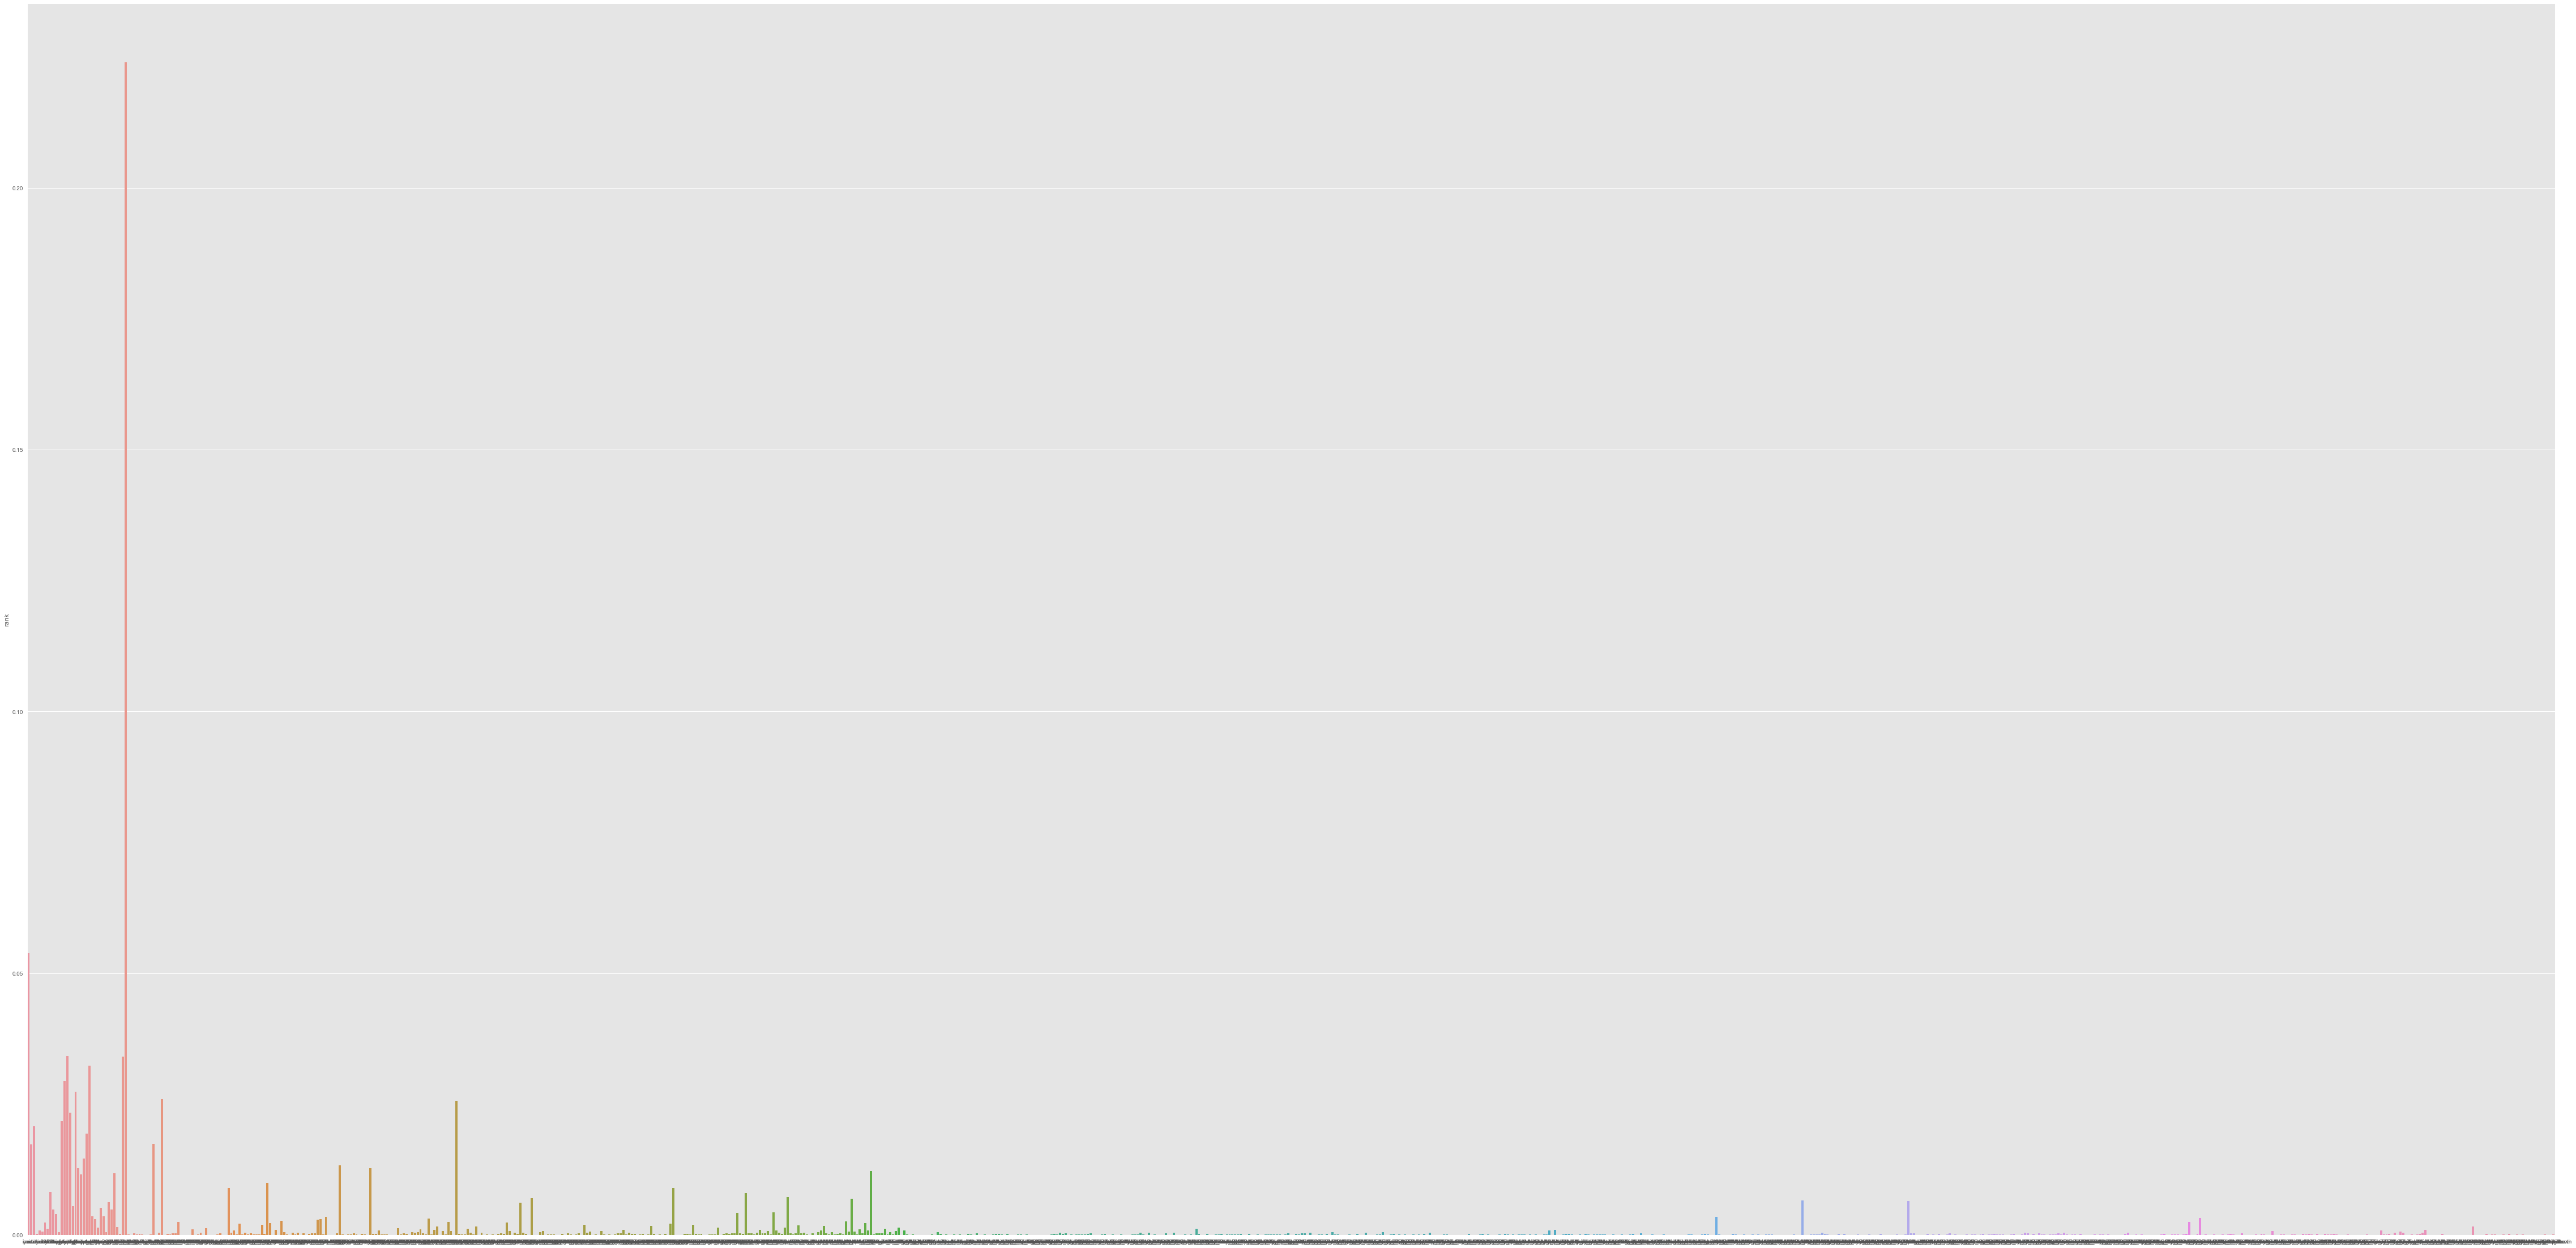

In [39]:
plt.figure(figsize=(80,40)) 
sns.barplot(x = X.columns, y = 'rank',  data = feature_rank, order = X.columns )
plt.show()

In [40]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.020
sfm = SelectFromModel(clf, threshold=0.020)

In [41]:
# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.02)

In [42]:
#Print the names of the most important features
imprt_columns = []
for feature_list_index in sfm.get_support(indices=True):
    imprt_columns.append(X.columns[feature_list_index])
print(imprt_columns)

['iyear', 'iday', 'attacktype1', 'targtype1', 'targsubtype1', 'natlty1', 'individual', 'weapsubtype1', 'INT_MISC', 'INT_ANY', 'gname_Anti-Abortion extremists', 'gname_Left-Wing Militants']


In [43]:
xxx = ijk[imprt_columns].reset_index(drop=True)
xxx.head()

,iyear,iday,attacktype1,targtype1,targsubtype1,natlty1,individual,weapsubtype1,INT_MISC,INT_ANY,gname_Anti-Abortion extremists,gname_Left-Wing Militants
0,1970,1,2,3,22.0,217.0,0,5.0,0,-9,0,0
1,1970,2,7,4,28.0,217.0,0,19.0,0,0,0,0
2,1970,3,7,2,21.0,217.0,0,20.0,0,0,0,0
3,1970,1,3,4,27.0,217.0,0,16.0,0,0,0,0
4,1970,6,7,4,28.0,217.0,0,19.0,0,-9,0,1


***Create A Data Subset With Only The Most Important Features***


In [44]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [45]:
#X_important_train[0]

***Train A New Random Forest Classifier Using Only Most Important Features***


In [46]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

***Compare The Accuracy Of Our Full Feature Classifier To Our Limited Feature Classifier***


In [47]:
#Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
accuracy_score(y_test, y_pred)

0.9660249150622876

In [48]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, y_important_pred)

0.96149490373725932

***Using K-Fold Cross-validation on original dataset for check for overfitting***

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold


In [50]:
def classification_model(model, X, y):
  #Perform k-fold cross-validation with 5 folds
    kf = KFold(n_splits=3, random_state=1, shuffle=True)
    error = []
    for train_index, test_index in kf.split(X):
    # Filter training data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        # The target we're using to train the algorithm.
        y_train, y_test = y[train_index], y[test_index]

        # Training the algorithm using the predictors and target.
        model.fit(X_train, y_train)

        #Record error from each cross-validation run
        error.append(model.score(X_test,y_test))
 
    print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))


In [51]:
for estimators in [30, 50, 100, 120, 150]:
    model = RandomForestClassifier(n_estimators=estimators)
    classification_model(model, X, y)

Cross-Validation Score : 96.283%
Cross-Validation Score : 96.056%
Cross-Validation Score : 96.328%
Cross-Validation Score : 96.283%
Cross-Validation Score : 96.146%


***Doublechecking Performance Metric Using Confusion Matrix***

In [52]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(y_test, y_important_pred)
#plot_confusion_matrix(confusion_mat)

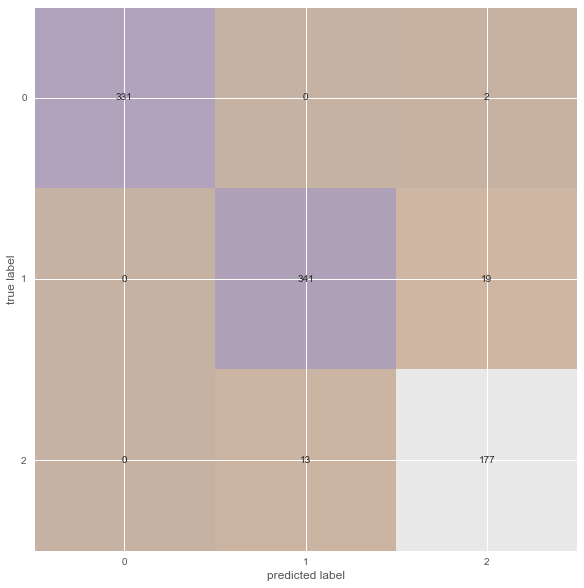

In [53]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat, figsize= [10, 10], cmap='PuOr')
plt.show()

In [54]:
#we can also see this model is predicting using the three classes with no predominant class affecting the model as shown below
np.unique(y_test)

array([-9,  0,  1], dtype=int64)

However, from the confusion matrix, we see some of the predictions were incorrect. This could be due to the imbalanced classes mention earlier in cell 32. For such cases, accuracy alone cannot be adequate to measure how well a model will perform on out of sample dataset. Other performance metrics are also needed in addition to that. One of such is the confusion matrix above. The matrix shows the likelihood of the model distinguishing between observations from different classes. In other words, if we randomly select one observation from each class, what's the probability that the model will be able to "rank" them correctly?

- For the Unknowns - represented by -9 with index 0, we see the model performed really well. 
- For cases of all nationality of terrorism perpetrator group same as the nationality of the target(s)/victim(s), represented as   0 with index 1, we see that the model got the prediction of 341 observations correctly, and 13 wrong.
- For cases of nationality of terrorism perpetrator group differing from the nationality of the target(s)/victim(s), represented   as 1 with index 2, we see that the model got the prediction of 177 observations correctly, and 19 wrong.




Although the accuracy is somewhat high with little or no overfitting, performance is still questionable as mentioned above. So, to resolve this, i will be looking at implementing measures that can used to balance classes, and comparing results with the above.  